In [7]:
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [19]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [21]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360050001000,4,0.000000,0.500000,0.000000,0.000000
1,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041
2,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470493005,4,8.588745,0.020101,0.020101,2.316296
3,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471134003,4,2.479008,0.008333,0.008333,0.668563
4,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471196002,4,0.212593,0.001224,0.001224,0.057334


In [28]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({'cdi': 'sum'}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df.head()

,date_range_start,cdi
0,2018-12-31 00:00:00-05:00,390609.769407
1,2019-01-07 00:00:00-05:00,630125.134950
2,2019-01-14 00:00:00-05:00,380460.447928
3,2019-01-21 00:00:00-05:00,241184.376961
4,2019-01-28 00:00:00-05:00,281566.233464


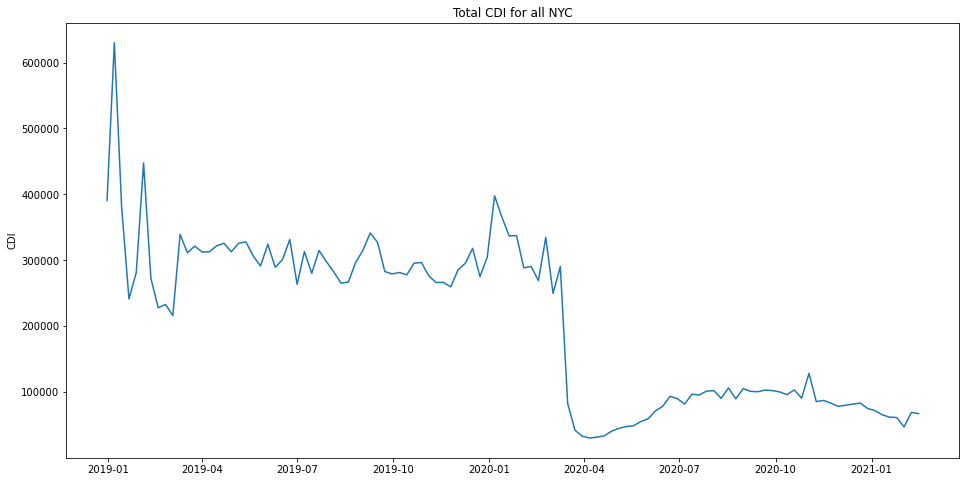

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_total_df['date_range_start'], cdi_total_df['cdi'])
ax.set_title('Total CDI for all NYC')
ax.set_ylabel('CDI')
plt.show()

In [45]:
cdi_week_df = cdi_total_df
cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week
cdi_week_df.iloc[95:105]

,date_range_start,cdi,year,week
95,2020-10-26 00:00:00-04:00,90678.073482,2020,44
96,2020-11-02 00:00:00-05:00,128439.081674,2020,45
97,2020-11-09 00:00:00-05:00,85513.766503,2020,46
98,2020-11-16 00:00:00-05:00,87220.032151,2020,47
99,2020-11-23 00:00:00-05:00,83207.553610,2020,48
100,2020-11-30 00:00:00-05:00,78358.964352,2020,49
101,2020-12-21 00:00:00-05:00,83301.524784,2020,52
102,2020-12-28 00:00:00-05:00,75156.680390,2020,53
103,2021-01-04 00:00:00-05:00,71920.651448,2021,1
104,2021-01-11 00:00:00-05:00,65611.861707,2021,2


In [46]:
# Dates are missing from December 2020!

In [60]:
cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
# Remove dates that can't be compared.
cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)

In [66]:
display(cdi_2019_df.head())
display(cdi_2020_df.head())

,date_range_start,cdi,year,week
0,2019-01-07 00:00:00-05:00,630125.134950,2019,2
1,2019-01-14 00:00:00-05:00,380460.447928,2019,3
2,2019-01-21 00:00:00-05:00,241184.376961,2019,4
3,2019-01-28 00:00:00-05:00,281566.233464,2019,5
4,2019-02-04 00:00:00-05:00,447745.305585,2019,6


,date_range_start,cdi,year,week
0,2020-01-06 00:00:00-05:00,397835.725201,2020,2
1,2020-01-13 00:00:00-05:00,365517.475701,2020,3
2,2020-01-20 00:00:00-05:00,336945.433057,2020,4
3,2020-01-27 00:00:00-05:00,337471.777632,2020,5
4,2020-02-03 00:00:00-05:00,288427.870884,2020,6


In [71]:
cdi_diff_df = cdi_2020_df[['cdi']] - cdi_2019_df[['cdi']]
cdi_diff_df['week'] = cdi_2020_df['week']
cdi_diff_df['date_range_start'] = cdi_2020_df['date_range_start']
cdi_diff_df.head()

,cdi,week,date_range_start
0,-232289.409749,2,2020-01-06 00:00:00-05:00
1,-14942.972227,3,2020-01-13 00:00:00-05:00
2,95761.056096,4,2020-01-20 00:00:00-05:00
3,55905.544168,5,2020-01-27 00:00:00-05:00
4,-159317.434700,6,2020-02-03 00:00:00-05:00


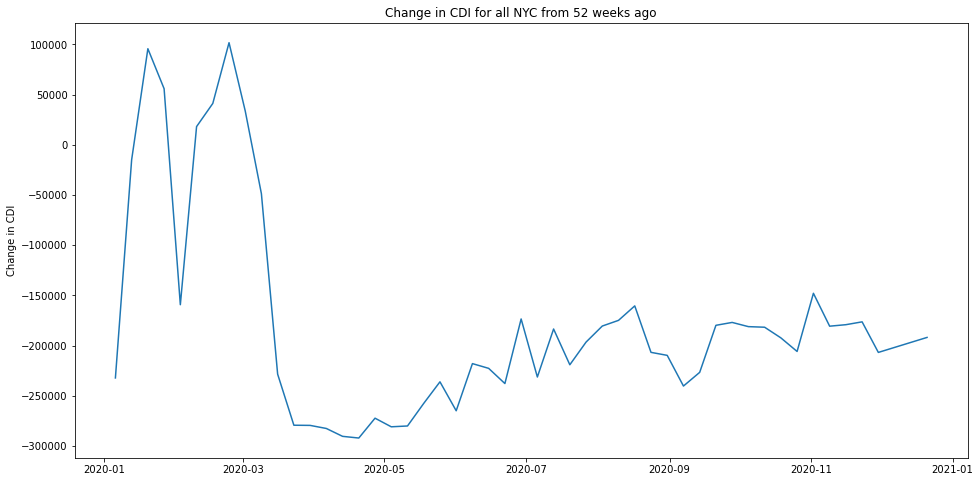

In [74]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('Change in CDI for all NYC from 52 weeks ago')
ax.set_ylabel('Change in CDI')
plt.show()